In [1]:
import sys
import inspect
import matplotlib.pyplot as plt

sys.path.append('../src')
from ARCSolver.hypothesis import Hypothesis
from ARCSolver.core import Core
from helpers.task import Task
from helpers.task_vis import *
from priors.primitives import *
from priors.primitives_kit import *
from synthesis.inventory import Inventory, InventoryController
from synthesis.genotype import GenotypeTemplate, GenotypeSolver

In [2]:
def get_task(category, id):
    input_dir = "../input"
    return Task(f'{input_dir}/{category}/{id}.json')

## Solvers

In [3]:
class BlindRandomFixedShapeSolver(Core):
    def __init__(self, inventory, fixed_depth = 1, fixed_shape=(1,), max_invalid_trials=100, max_incorrect_trials=100, temperature=0.5):
        primitives = inspect.getmembers(inventory.primitives_kit, predicate=inspect.isfunction)
        self.n_primitives = len(primitives)
        self.inventory = inventory
        self.fixed_shape = fixed_shape
        self.fixed_depth = fixed_depth
        self.temperature = temperature
        self.max_invalid_trials = max_invalid_trials
        self.max_incorrect_trials = max_incorrect_trials
        self.fts = 0
    
    def __study_task_examples(self, tsk: Task) -> Hypothesis:
        ins, outs = zip(*tsk.get_examples())
        hypothesis = None

        for _ in range(self.max_incorrect_trials):
            hypothesis = None
            t = GenotypeTemplate(shape = self.fixed_shape, depth = self.fixed_depth, is_exact = True, signature = (PrimitivesKit.Grid, (PrimitivesKit.Grid,)) )
            try:
                key = None
                for _ in range(self.max_invalid_trials):
                    try:
                        key = self.inventory.generate(template = t, temperature = self.temperature)
                        if key: break
                    except: pass
                if key is None: raise AssertionError('Genotype Cannot be generated')
                solver = GenotypeSolver(self.inventory[key], self.inventory)
                hypothesis = Hypothesis(solver)
                if hypothesis.test(ins, outs) == False: raise AssertionError('Wrong Hypothesis')
                else: break
            except:
                self.fts += 1
        
        return hypothesis


    def study_train_task(self, tsk: Task) -> Hypothesis:
        hypothesis = self.__study_task_examples(tsk)
        return hypothesis if hypothesis and hypothesis.test(tsk.get_tests(), tsk.get_solutions()) else None

    def solve_test_task(self, task: Task) -> Hypothesis:
        return self.__study_task_examples()

    def get_fts(self):
        return self.fts

    def do_sleep(self):
        ''' Reorganizes KB while asleep. '''
        pass

In [4]:
class BlindRandomGrowingShapeSolver(Core):
    def __init__(self, inventory, max_size=10, max_depth=1, max_invalid_trials=100, max_incorrect_trials=100, temperature=0.5):
        primitives = inspect.getmembers(inventory.primitives_kit, predicate=inspect.isfunction)
        self.n_primitives = len(primitives)
        self.inventory = inventory
        self.max_size = max_size
        self.max_depth = max_depth
        self.temperature = temperature
        self.max_invalid_trials = max_invalid_trials
        self.max_incorrect_trials = max_incorrect_trials
        self.fts = 0
    
    def __make_template(self):
        depth = randint(1, self.max_depth)
        shape = InventoryController.shape_of_size(randint(1, self.max_size))
        return GenotypeTemplate(shape = shape, depth = depth, is_exact = True, signature = (PrimitivesKit.Grid, (PrimitivesKit.Grid,)) )
    
    def __study_task_examples(self, tsk: Task) -> Hypothesis:
        ins, outs = zip(*tsk.get_examples())
        hypothesis = None

        for _ in range(self.max_incorrect_trials):
            hypothesis = None
            try:
                key = None
                for _ in range(self.max_invalid_trials):
                    try:
                        key = self.inventory.generate(template = self.__make_template(), temperature = self.temperature)
                        if key: break
                    except: pass
                if key is None: raise AssertionError('Genotype Cannot be generated')
                solver = GenotypeSolver(self.inventory[key], self.inventory)
                hypothesis = Hypothesis(solver)
                if hypothesis.test(ins, outs) == False: raise AssertionError('Wrong Hypothesis')
                else: break
            except:
                self.fts += 1
        
        return hypothesis


    def study_train_task(self, tsk: Task) -> Hypothesis:
        hypothesis = self.__study_task_examples(tsk)
        return hypothesis if hypothesis and hypothesis.test(tsk.get_tests(), tsk.get_solutions()) else None

    def solve_test_task(self, task: Task) -> Hypothesis:
        return self.__study_task_examples()

    def get_fts(self):
        return self.fts

    def do_sleep(self):
        ''' Reorganizes KB while asleep. '''
        pass

# Experiments A

In [5]:
def copyType(C):
    return type('CopyOfC', C.__bases__, dict(C.__dict__))

def get_method_names(cls):
    methods = inspect.getmembers(cls, predicate=inspect.isfunction)
    return [method[0] for method in methods]

def delete_methods(cls, methods):
    for method in methods:
        delattr(cls, method)

def create_kit_variations(kit, essentials):
    kits = []
    method_names = list(set(get_method_names(kit)) - set(essentials))
    for n in reversed(range(len(method_names)+1)):
        k = copyType(kit)
        delete_methods(k, method_names[:n])
        kits.append(k)

    return kits

essential_methods = [
    'render',
    'create_unicolor_grid',
    'get_size',
    'frgnd_clrs_by_majority',
    'select_first',
]

kits = create_kit_variations(PrimitivesKit, essentials=essential_methods)

In [6]:
# task_A1 = get_task("synthetic", "s00")
task_A1 = get_task("synthetic", "s01")

# task_A2 = get_task("training", "0b148d64")
task_A2 = get_task("training", "9af7a82c")

In [7]:
iterations = 1000
max_invalid_trials = 100
max_incorrect_trials = 10

## Experiment A.1/2 Common

In [8]:
def perform_experiment_A12(kit, tsk, make_solver, iterations):
    fts = []
    inv_sizes = []
    successes = 0

    for i in range(iterations):
        inventory = Inventory(kit=kit)
        orig_inv_size = inventory.get_n_genotypes()
        solver = make_solver(inventory)
        h = solver.study_train_task(tsk)
        if h and h.test(tsk.get_tests(), tsk.get_solutions()):
            fts.append(solver.get_fts())
            successes += 1
        inv_sizes.append(inventory.get_n_genotypes() / orig_inv_size)
        print(f'iteration: {i+1}, inventory size: {inventory.get_n_primitives()}/{inventory.get_n_genotypes()}, success: {successes}/{iterations}', end='\r')

    
    avg_fts = (sum(fts) / len(fts)) if len(fts) else None
    avg_rel_inv_size = sum(inv_sizes) / len(inv_sizes)

    return {'n_successes': successes, 'avg_fts': avg_fts, 'avg_rel_inv_size': avg_rel_inv_size}


def interpret_A12_results(results):
    print('\nResults:')
    for result in results:
        print(result)

## Experiment A.1

### Experiment A.1.a

In [9]:
def make_solver_A1a(inventory):
    return BlindRandomFixedShapeSolver(
        inventory, 
        fixed_depth=1, 
        fixed_shape=(1, 1, 2, 1), 
        max_invalid_trials=max_invalid_trials, 
        max_incorrect_trials=max_incorrect_trials)

# Test agains Kit size

results = []
for i, kit in enumerate(kits):
    print(f'kit {i}/{len(kits)}:')
    results.append(perform_experiment_A12(kit, task_A1, make_solver_A1a, iterations=iterations))
    print('')

interpret_A12_results(results)

avg_fts = [d['avg_fts'] for d in results]
success_rate = [d['n_successes']/iterations for d in results]
avg_rel_inv_size = [d['avg_rel_inv_size'] for d in results]



kit 0/32:
iteration: 1000, inventory size: 5/6, success: 1000/1000
kit 1/32:
iteration: 1000, inventory size: 6/7, success: 698/1000
kit 2/32:
iteration: 1000, inventory size: 7/8, success: 705/1000
kit 3/32:
iteration: 1000, inventory size: 8/9, success: 696/1000
kit 4/32:
iteration: 1000, inventory size: 9/11, success: 693/1000
kit 5/32:
iteration: 1000, inventory size: 10/11, success: 635/1000
kit 6/32:
iteration: 1000, inventory size: 11/12, success: 665/1000
kit 7/32:
iteration: 1000, inventory size: 12/15, success: 647/1000
kit 8/32:
iteration: 1000, inventory size: 13/14, success: 656/1000
kit 9/32:
iteration: 1000, inventory size: 14/15, success: 676/1000
kit 10/32:
iteration: 1000, inventory size: 15/16, success: 661/1000
kit 11/32:
iteration: 1000, inventory size: 16/17, success: 648/1000
kit 12/32:
iteration: 1000, inventory size: 17/18, success: 652/1000
kit 13/32:
iteration: 1000, inventory size: 18/20, success: 652/1000
kit 14/32:
iteration: 1000, inventory size: 19/20, s

Text(0.5, 0, 'Extra/Non-essential Primitives in DSL')

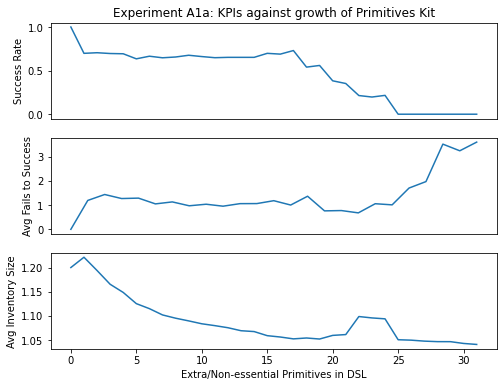

In [10]:

plt.figure(figsize=(8,6))

plt.subplot(3, 1, 1)
plt.title('Experiment A1a: KPIs against growth of Primitives Kit')
plt.plot(success_rate,)
plt.ylabel('Success Rate')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(3, 1, 2)
plt.plot(avg_fts, )
plt.ylabel('Avg Fails to Success')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(3, 1, 3)
plt.plot(avg_rel_inv_size, )
plt.ylabel('Avg Inventory Size')
plt.xlabel('Extra/Non-essential Primitives in DSL')

### Experiment A.1.b

In [9]:
def make_solver_A1b(max_depth, max_size):
    return lambda inventory: BlindRandomGrowingShapeSolver(
        inventory, 
        max_depth=max_depth, 
        max_size=max_size, 
        max_invalid_trials=max_invalid_trials, 
        max_incorrect_trials=max_incorrect_trials)

avg_size = 5
avg_depth = 5
size_range = range(1, 20)
depth_range = range(1, 20)

Depth 1/19:
iteration: 1000, inventory size: 13/14, success: 223/1000
Depth 2/19:
iteration: 1000, inventory size: 13/16, success: 213/1000
Depth 3/19:
iteration: 1000, inventory size: 13/15, success: 240/1000
Depth 4/19:
iteration: 1000, inventory size: 13/15, success: 214/1000
Depth 5/19:
iteration: 1000, inventory size: 13/14, success: 208/1000
Depth 6/19:
iteration: 1000, inventory size: 13/14, success: 235/1000
Depth 7/19:
iteration: 1000, inventory size: 13/14, success: 209/1000
Depth 8/19:
iteration: 1000, inventory size: 13/16, success: 214/1000
Depth 9/19:
iteration: 1000, inventory size: 13/15, success: 223/1000
Depth 10/19:
iteration: 1000, inventory size: 13/15, success: 215/1000
Depth 11/19:
iteration: 1000, inventory size: 13/14, success: 220/1000
Depth 12/19:
iteration: 1000, inventory size: 13/14, success: 214/1000
Depth 13/19:
iteration: 1000, inventory size: 13/15, success: 208/1000
Depth 14/19:
iteration: 1000, inventory size: 13/14, success: 203/1000
Depth 15/19:
it

Text(0.5, 0, 'Graph Depth')

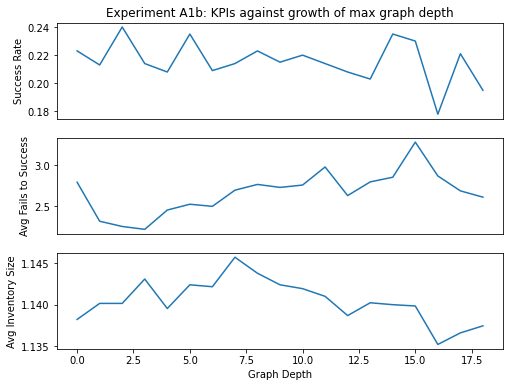

In [15]:
# Test against depth

results = []
for depth in depth_range:
    print(f'Depth {depth}/{len(depth_range)}:')
    results.append(
        perform_experiment_A12(PrimitivesKit, task_A1, make_solver_A1b(max_depth=depth, max_size=avg_size) , iterations=iterations))
    print('')

interpret_A12_results(results)

avg_fts = [d['avg_fts'] for d in results]
success_rate = [d['n_successes']/iterations for d in results]
avg_rel_inv_size = [d['avg_rel_inv_size'] for d in results]

plt.figure(figsize=(8,6))

plt.subplot(3, 1, 1)
plt.title('Experiment A1b: KPIs against growth of max graph depth')
plt.plot(success_rate,)
plt.ylabel('Success Rate')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(3, 1, 2)
plt.plot(avg_fts, )
plt.ylabel('Avg Fails to Success')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(3, 1, 3)
plt.plot(avg_rel_inv_size, )
plt.ylabel('Avg Inventory Size')
plt.xlabel('Graph Depth')


In [12]:
iterations = 250
max_invalid_trials = 100
max_incorrect_trials = 10
avg_size = 5
avg_depth = 5
size_range = range(1, 20)
depth_range = range(1, 20)

Size 1/19:
iteration: 250, inventory size: 13/13, success: 0/250
Size 2/19:
iteration: 250, inventory size: 13/14, success: 0/250
Size 3/19:
iteration: 250, inventory size: 13/15, success: 0/250
Size 4/19:
iteration: 250, inventory size: 13/15, success: 43/250
Size 5/19:
iteration: 250, inventory size: 13/14, success: 51/250
Size 6/19:
iteration: 250, inventory size: 13/14, success: 51/250
Size 7/19:
iteration: 250, inventory size: 13/15, success: 45/250
Size 8/19:
iteration: 250, inventory size: 13/14, success: 42/250
Size 9/19:
iteration: 250, inventory size: 13/15, success: 41/250
Size 10/19:
iteration: 250, inventory size: 13/15, success: 48/250
Size 11/19:
iteration: 250, inventory size: 13/15, success: 43/250
Size 12/19:
iteration: 250, inventory size: 13/14, success: 36/250
Size 13/19:
iteration: 250, inventory size: 13/15, success: 40/250
Size 14/19:
iteration: 250, inventory size: 13/14, success: 34/250
Size 15/19:
iteration: 250, inventory size: 13/15, success: 33/250
Size 16

Text(0.5, 0, 'Graph Size')

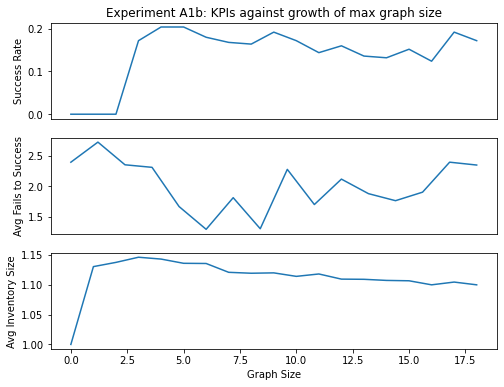

In [13]:
# Test against size

results = []
for size in size_range:
    print(f'Size {size}/{len(size_range)}:')
    results.append(
        perform_experiment_A12(PrimitivesKit, task_A1, make_solver_A1b(max_depth=avg_depth, max_size=size) , iterations=iterations))
    print('')

interpret_A12_results(results)

avg_fts = [d['avg_fts'] for d in results]
success_rate = [d['n_successes']/iterations for d in results]
avg_rel_inv_size = [d['avg_rel_inv_size'] for d in results]

plt.figure(figsize=(8,6))

plt.subplot(3, 1, 1)
plt.title('Experiment A1b: KPIs against growth of max graph size')
plt.plot(success_rate,)
plt.ylabel('Success Rate')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(3, 1, 2)
plt.plot(avg_fts, )
plt.ylabel('Avg Fails to Success')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.subplot(3, 1, 3)
plt.plot(avg_rel_inv_size, )
plt.ylabel('Avg Inventory Size')
plt.xlabel('Graph Size')


## Experiment A.2

### Experiment A.2.a

In [ ]:
def make_solver_A2a(inventory):
    return BlindRandomFixedShapeSolver(inventory, fixed_depth=1, fixed_shape=(1, 1, 2, 1), max_invalid_trials=10, max_incorrect_trials=10)

results = perform_experiment_A12(kits, task_A2, make_solver_A2a, iterations=1000)
interpret_A12_results(results)

### Experiment A.2.b

In [ ]:
def make_solver_A2b(inventory):
    return BlindRandomGrowingShapeSolver(inventory, max_depth=5, max_size=10, max_invalid_trials=10, max_incorrect_trials=10)

results = perform_experiment_A12(kits, task_A2, make_solver_A2b, iterations=1000)
interpret_A12_results(results)